# Parte 3: Predicción de precio de Bitcoin mediante RNN
## Álvaro Andrés Esquivel Gómez 11002822

### Planteamiento del problema

El dataset incluye los datos históricos del mercado de bitcoins a intervalos de 1 minuto para los intercambios de bitcoins seleccionados donde se realiza el comercio. Con esta información, de realizará una predicción de los precios de Bitcoin mediante el uso de redes neuronales recurrentes.

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
#Lectura de datos
df = pd.read_csv('coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv')

In [3]:
df

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,300.00,300.00,300.00,300.00,0.010000,3.000000,300.000000
1,1417412040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1417412100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1417412160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1417412220,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2099755,1546898520,4006.01,4006.57,4006.00,4006.01,3.382954,13553.433078,4006.390309
2099756,1546898580,4006.01,4006.57,4006.00,4006.01,0.902164,3614.083169,4006.017233
2099757,1546898640,4006.01,4006.01,4006.00,4006.01,1.192123,4775.647308,4006.003635
2099758,1546898700,4006.01,4006.01,4005.50,4005.50,2.699700,10814.241898,4005.719991


## Análisis de datos

In [4]:
#Transformacion de tipo de fecha
df['fecha'] = pd.to_datetime(df['Timestamp'],unit='s').dt.date


In [5]:
#Valores transformados
df

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,fecha
0,1417411980,300.00,300.00,300.00,300.00,0.010000,3.000000,300.000000,2014-12-01
1,1417412040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-01
2,1417412100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-01
3,1417412160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-01
4,1417412220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-01
...,...,...,...,...,...,...,...,...,...
2099755,1546898520,4006.01,4006.57,4006.00,4006.01,3.382954,13553.433078,4006.390309,2019-01-07
2099756,1546898580,4006.01,4006.57,4006.00,4006.01,0.902164,3614.083169,4006.017233,2019-01-07
2099757,1546898640,4006.01,4006.01,4006.00,4006.01,1.192123,4775.647308,4006.003635,2019-01-07
2099758,1546898700,4006.01,4006.01,4005.50,4005.50,2.699700,10814.241898,4005.719991,2019-01-07


In [6]:
#Transformacion de datos a valores diarios
group = df.groupby('fecha')
Precio_x_dia = group['Weighted_Price'].mean()

Precio_x_dia, len(Precio_x_dia)

(fecha
 2014-12-01     335.000000
 2014-12-02     377.854911
 2014-12-03     377.818333
 2014-12-04     377.100000
 2014-12-06     378.000000
                  ...     
 2019-01-03    3829.900978
 2019-01-04    3785.337456
 2019-01-05    3834.565401
 2019-01-06    3874.337968
 2019-01-07    4025.017616
 Name: Weighted_Price, Length: 1465, dtype: float64,
 1465)

In [7]:
#Division de informacion para los ultimos 30 dias 

df_test= Precio_x_dia[len(Precio_x_dia)-30:]
df_train= Precio_x_dia[:len(Precio_x_dia)-30]

In [8]:
df_train.shape, df_test.shape

((1435,), (30,))

In [9]:
#Transformacion de shape training set
training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
print(training_set, training_set.shape)

[[ 335.        ]
 [ 377.85491071]
 [ 377.81833333]
 ...
 [3694.95778355]
 [3358.48618463]
 [3384.38308658]] (1435, 1)


In [10]:
#Aplicando normalizacion utilizando MinMaxScaler

sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

In [11]:
X_train.shape, y_train.shape

((1434, 1, 1), (1434, 1))

## Creación de modelo RNN 

Para solucionar predecir los valores de una serie temporal se implementa una aquitectura con neuronas recurrentes especificamente del tipo Long short-term memory (LSTM), especificamente se utiizarán cuatro unidades con ativación sigmoid y una neurona con capa de salida.

In [12]:
#Creacion modelo RNN

modelo_rnn_bitcoin = keras.models.Sequential([

    # Agrega capa de tipo LSTM layer
    keras.layers.LSTM(units = 4, activation = 'sigmoid', input_shape = (None, 1)),

    # Capa de salida
    keras.layers.Dense(units = 1)

])


In [13]:
#Compilacion del modelo
modelo_rnn_bitcoin.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [14]:
#Entrenamieto

history = modelo_rnn_bitcoin.fit(X_train, y_train, 
                                 batch_size = 5, epochs = 100)

Train on 1434 samples
Epoch 1/100
1434/1434 [==============================] - 1s 805us/sample - loss: 0.0455
Epoch 2/100
1434/1434 [==============================] - 0s 291us/sample - loss: 0.0359s - loss: 
Epoch 3/100
1434/1434 [==============================] - 0s 301us/sample - loss: 0.0341s - loss: 0.03
Epoch 4/100
1434/1434 [==============================] - 0s 269us/sample - loss: 0.0315
Epoch 5/100
1434/1434 [==============================] - 0s 247us/sample - loss: 0.0279
Epoch 6/100
1434/1434 [==============================] - 0s 253us/sample - loss: 0.0229
Epoch 7/100
1434/1434 [==============================] - 0s 236us/sample - loss: 0.0172
Epoch 8/100
1434/1434 [==============================] - 0s 291us/sample - loss: 0.0112
Epoch 9/100
1434/1434 [==============================] - 0s 242us/sample - loss: 0.0063
Epoch 10/100
1434/1434 [==============================] - 0s 258us/sample - loss: 0.0030
Epoch 11/100
1434/1434 [==============================] - 0s 258us/sample

1434/1434 [==============================] - 0s 301us/sample - loss: 1.5516e-04
Epoch 88/100
1434/1434 [==============================] - 0s 221us/sample - loss: 1.6123e-04s - loss: 2.3144
Epoch 89/100
1434/1434 [==============================] - 0s 232us/sample - loss: 1.5570e-04
Epoch 90/100
1434/1434 [==============================] - 0s 225us/sample - loss: 1.5645e-04
Epoch 91/100
1434/1434 [==============================] - 0s 231us/sample - loss: 1.6034e-04
Epoch 92/100
1434/1434 [==============================] - 0s 232us/sample - loss: 1.5776e-04
Epoch 93/100
1434/1434 [==============================] - 0s 221us/sample - loss: 1.5895e-04
Epoch 94/100
1434/1434 [==============================] - 0s 236us/sample - loss: 1.5872e-04
Epoch 95/100
1434/1434 [==============================] - 0s 232us/sample - loss: 1.5553e-04
Epoch 96/100
1434/1434 [==============================] - 0s 247us/sample - loss: 1.5441e-04
Epoch 97/100
1434/1434 [==============================] - 0s 221us/

In [19]:
#Aplicando normalizacion MinMax a test set

test_set = df_test.values[1:]
test_set_norm = np.reshape(df_test.values[0:len(df_test)-1], (len(test_set), 1))
test_set_norm = sc.fit_transform(test_set_norm)
test_set_norm = np.reshape(test_set_norm, (len(test_set_norm), 1, 1))
test_set_norm, test_set_norm.shape

(array([[[0.30528367]],
 
        [[0.30645455]],
 
        [[0.19620801]],
 
        [[0.22895952]],
 
        [[0.19098011]],
 
        [[0.05740743]],
 
        [[0.        ]],
 
        [[0.03980081]],
 
        [[0.16181043]],
 
        [[0.34762432]],
 
        [[0.60188879]],
 
        [[0.78677353]],
 
        [[0.83875455]],
 
        [[0.71068819]],
 
        [[0.84415048]],
 
        [[1.        ]],
 
        [[0.62761316]],
 
        [[0.62905232]],
 
        [[0.56834184]],
 
        [[0.55093744]],
 
        [[0.73374605]],
 
        [[0.64365826]],
 
        [[0.60950352]],
 
        [[0.55032707]],
 
        [[0.67990235]],
 
        [[0.68703441]],
 
        [[0.63994031]],
 
        [[0.69196371]],
 
        [[0.73399479]]]),
 (29, 1, 1))

In [20]:
#Prediccion de precios utilizando modelo RNN
prediccion_precios = modelo_rnn_bitcoin.predict(test_set_norm)
prediccion_precios = sc.inverse_transform(prediccion_precios)
prediccion_precios, prediccion_precios.shape

(array([[3468.9744],
        [3470.1245],
        [3363.1128],
        [3394.565 ],
        [3358.126 ],
        [3234.83  ],
        [3184.821 ],
        [3219.2776],
        [3330.496 ],
        [3510.664 ],
        [3757.2146],
        [3919.8694],
        [3961.5876],
        [3855.4353],
        [3965.8052],
        [4078.0398],
        [3781.0078],
        [3782.3293],
        [3725.7302],
        [3709.2122],
        [3875.3647],
        [3795.6812],
        [3764.291 ],
        [3708.6304],
        [3828.3142],
        [3834.6475],
        [3792.293 ],
        [3839.0076],
        [3875.5781]], dtype=float32),
 (29, 1))

In [21]:
#Visualización de resultados

def graf_resultados(test_set, valor_real, prediccion):
    plt.figure(figsize=(20,10), dpi=80)
    ax = plt.gca()  
    #Grafica valores reales
    plt.plot(test_set, color = 'red', label = 'Precio real Bitcoin')
    #Grafica prediccion de valores
    plt.plot(prediccion, color = 'blue', label = 'Predicción de precio Bitcon')
    plt.title('Predicción de precios de Bitcoin', fontsize=28)
    valor_real_index = valor_real.reset_index()
    x = valor_real_index.index
    #Fechas
    labels = valor_real_index['fecha']
    plt.xticks(x, labels, rotation = 'vertical')
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(18)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(18)
    plt.xlabel('Fecha', fontsize=20)
    plt.ylabel('Precio Bitcoin USD', fontsize=20)
    plt.legend(loc=2, prop={'size': 18})
    plt.show()


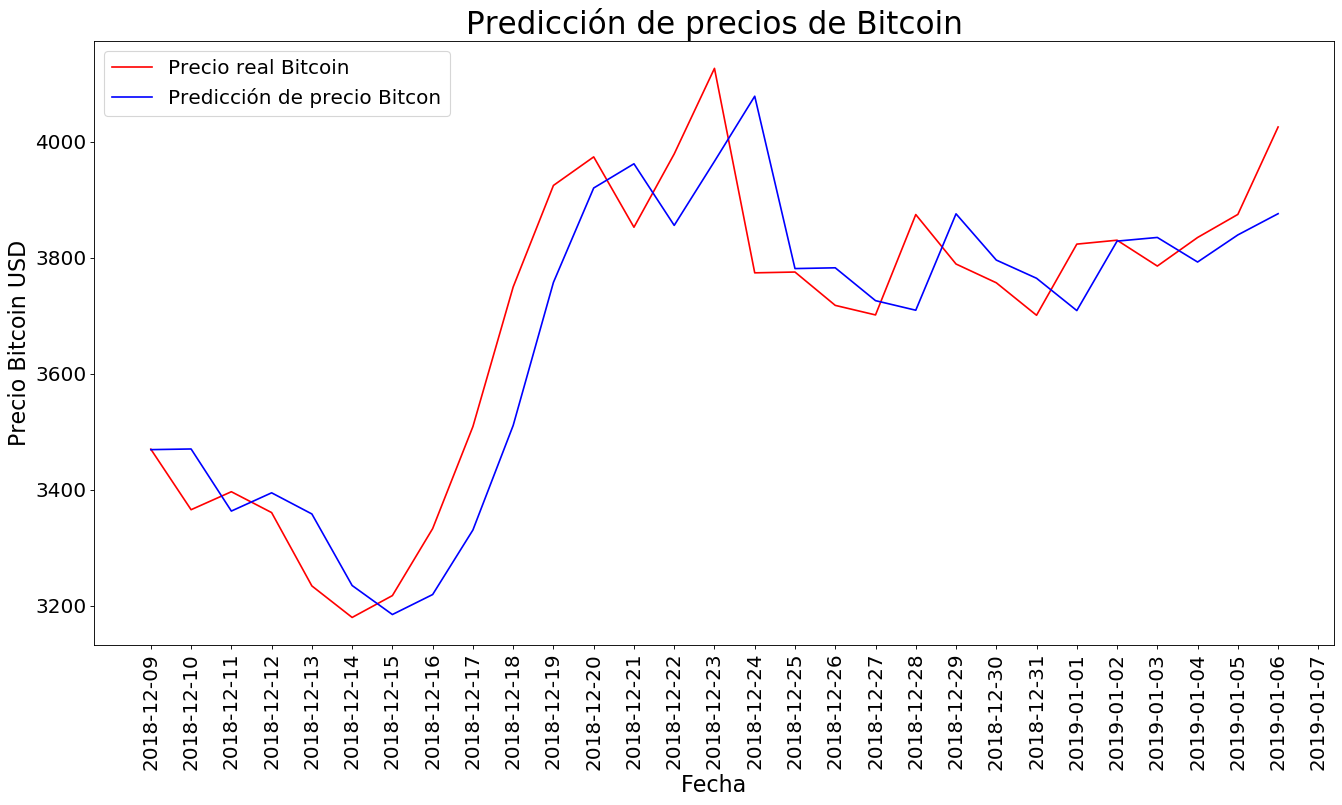

In [22]:
graf_resultados(test_set, df_test, prediccion_precios)

### Segundo modelo RNN 

Con fines de experimentación se para este modelo se aumenta el número de neuronas de la primer capa a 20, dejando el reto de parámetros iguales, con la finalidad de determinar el modelo tiene una aproximación más cercana a la realidad del precio.


In [31]:
#Creacion modelo Deep RNN

modelo_deep_rnn_bitcoin = keras.models.Sequential([

    # Agrega capa de tipo LSTM layer
    keras.layers.LSTM(20, return_sequences=False, activation = 'sigmoid', input_shape = (None, 1)),

    # Capa de salida
    keras.layers.Dense(units = 1)

])

In [32]:
#Compilacion del modelo
modelo_deep_rnn_bitcoin.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [33]:
#Entrenamieto

history = modelo_deep_rnn_bitcoin.fit(X_train, y_train, 
                                 batch_size = 5, epochs = 100)

Train on 1434 samples
Epoch 1/100
1434/1434 [==============================] - 1s 868us/sample - loss: 0.0413
Epoch 2/100
1434/1434 [==============================] - 0s 269us/sample - loss: 0.0221
Epoch 3/100
1434/1434 [==============================] - 0s 301us/sample - loss: 0.0130
Epoch 4/100
1434/1434 [==============================] - 0s 280us/sample - loss: 0.0061
Epoch 5/100
1434/1434 [==============================] - 0s 258us/sample - loss: 0.0021
Epoch 6/100
1434/1434 [==============================] - 0s 258us/sample - loss: 5.6670e-04
Epoch 7/100
1434/1434 [==============================] - 0s 253us/sample - loss: 1.9991e-04
Epoch 8/100
1434/1434 [==============================] - 0s 258us/sample - loss: 1.4882e-04
Epoch 9/100
1434/1434 [==============================] - 0s 269us/sample - loss: 1.4566e-04
Epoch 10/100
1434/1434 [==============================] - 0s 242us/sample - loss: 1.4816e-04
Epoch 11/100
1434/1434 [==============================] - 0s 258us/sample - l

1434/1434 [==============================] - 0s 275us/sample - loss: 1.5947e-04
Epoch 89/100
1434/1434 [==============================] - 0s 225us/sample - loss: 1.6055e-04
Epoch 90/100
1434/1434 [==============================] - 0s 253us/sample - loss: 1.6294e-04
Epoch 91/100
1434/1434 [==============================] - 0s 269us/sample - loss: 1.5944e-04
Epoch 92/100
1434/1434 [==============================] - 0s 236us/sample - loss: 1.5289e-04
Epoch 93/100
1434/1434 [==============================] - 0s 232us/sample - loss: 1.5894e-04
Epoch 94/100
1434/1434 [==============================] - 0s 232us/sample - loss: 1.6208e-04
Epoch 95/100
1434/1434 [==============================] - 0s 225us/sample - loss: 1.5740e-04
Epoch 96/100
1434/1434 [==============================] - 0s 232us/sample - loss: 1.6188e-04s - loss: 1.6634e-0
Epoch 97/100
1434/1434 [==============================] - 0s 242us/sample - loss: 1.5776e-04
Epoch 98/100
1434/1434 [==============================] - 0s 269

In [27]:
#Aplicando normalizacion MinMax a test set

test_set = df_test.values[1:]
test_set_norm = np.reshape(df_test.values[0:len(df_test)-1], (len(test_set), 1))
test_set_norm = sc.fit_transform(test_set_norm)
test_set_norm = np.reshape(test_set_norm, (len(test_set_norm), 1, 1))

In [28]:
#Prediccion de precios utilizando modelo RNN
prediccion_precios = modelo_deep_rnn_bitcoin.predict(test_set_norm)
prediccion_precios = sc.inverse_transform(prediccion_precios)

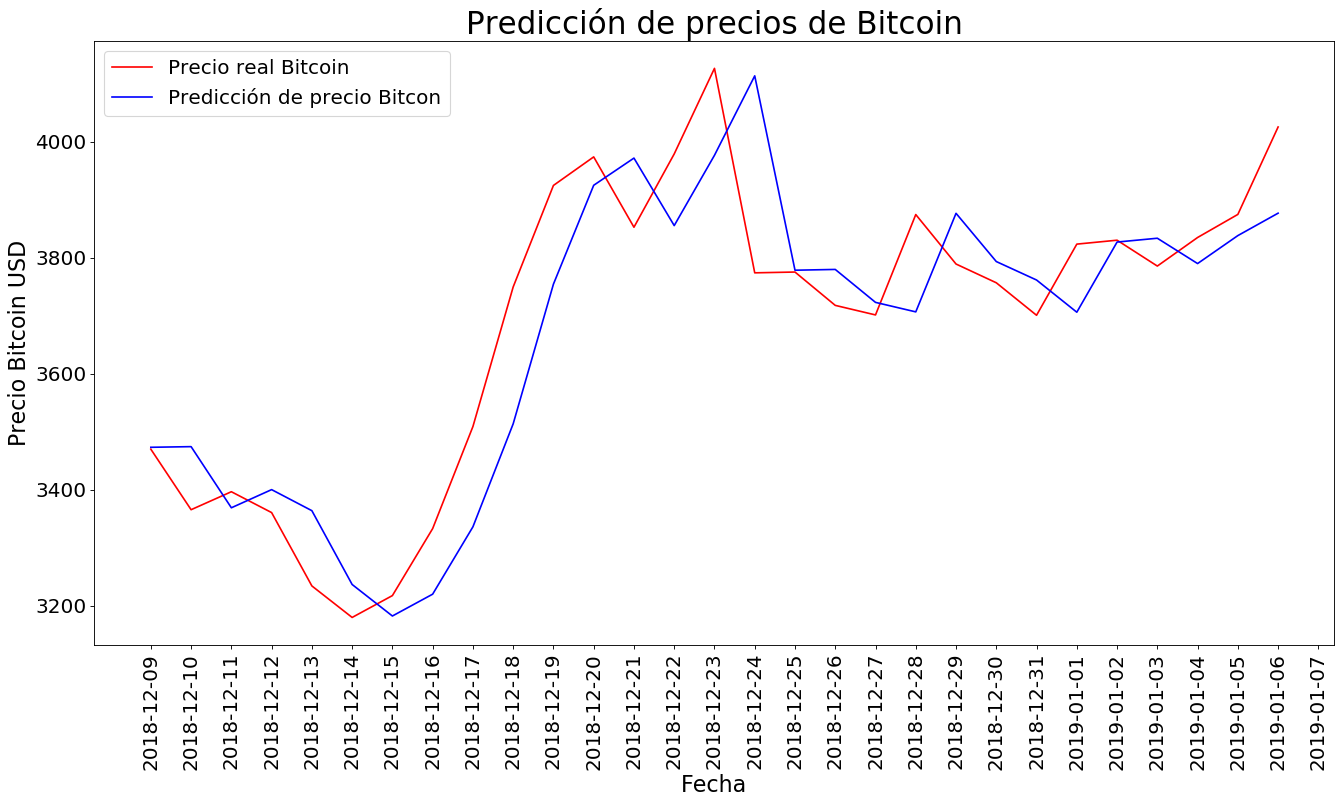

In [29]:
graf_resultados(test_set, df_test, prediccion_precios)